In [1]:
import torch
import scipy as sc
import numpy as np
from PIL import Image
import os
import re
import torch.nn.functional as F
import cv2
import numpy as np
from plantcv import plantcv as pcv
from matplotlib.patches import Patch
from scipy.io import loadmat, savemat
import torch.nn as nn
from tensorflow.keras.optimizers import Adam
from torch.autograd import Variable
from torchvision.models import resnet
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchmetrics.detection import IntersectionOverUnion

import matplotlib.pyplot as plt

In [2]:
def get_accuracy(output, target):
    # Assuming output and target are torch tensors with values of 0 or 1
    correct_pixels = np.equal(output, target).sum().item()
    # correct_pixels = 0
    # for w in range(output.shape[0]):
    #     for h in range(output.shape[1]):
    #         if output[w][h] == target[w][h]:
    #             correct_pixels +=1
    total_pixels = target.size

    # print(output.shape)
    # print(output.shape)
    # print(total_pixels)
    # print(correct_pixels)
    accuracy = correct_pixels / total_pixels
    return accuracy

In [3]:
def get_IoU(output, target):
    # Assuming output and target are torch tensors with values of 0 or 1
    intersection = np.logical_and(output, target).sum().item()
    union = np.logical_or(output, target).sum().item()

    iou = intersection / union if union != 0 else 0.0
    return iou

In [4]:
def dice_coefficient(prediction, target,  flag, smooth=1e-5):
    pred = np.copy(prediction)
    tar = np.copy(target)

    pred = torch.from_numpy(pred)
    tar = torch.from_numpy(tar)
    
    if flag =='disk':
        pred[pred == 2] = 0
        tar[tar ==2] =0
    if flag =='cup':
        pred[pred == 1] = 0
        pred[pred == 2] = 1
        tar[tar ==1] =0
        tar[tar ==2] =1
    intersection = torch.sum(pred * tar)
    union = torch.sum(pred) + torch.sum(tar)
    
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.item()

In [5]:
def confusion_matrix(prediction, target, flag = "disk"):
    output = np.copy(prediction)
    check = 0
    if flag == "disk":
        check = 1
    if flag == "cup":
        check = 2
        
    total = output.size
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    postive = 0
    negative = 0
    for w in range(output.shape[0]):
        for h in range(output.shape[1]):
            if check == 1 and target[w][h]==1:
                postive+=1
            if target[w][h] == 0:
                negative +=1
                
            if target[w][h] == check and output[w][h] ==check:
                TP +=1
                output[w][h] = 3
                continue
            if target[w][h] != check and output[w][h] !=check:
                TN +=1
                output[w][h] = 4
                continue
            if target[w][h] != check and output[w][h] == check:
                FP +=1
                output[w][h] = 5
                continue
            if target[w][h] == check and output[w][h] != check:
                FN += 1
                output[w][h] = 6
                continue

    output = output.astype(np.uint8)
    image = cv2.cvtColor(output, cv2.COLOR_GRAY2RGB)
    print(output.shape)
    image[output[:,:] == 3] = [0, 255, 0] #TP GREEN
    image[output[:,:] == 4] = [0, 0, 255] #TN blue
    image[output[:,:] == 5] = [255, 0, 0] # FP red
    image[output[:,:] == 6] = [255, 255, 0] #FN yellow
    
    return TP/total, TN/total, FP/total, FN/total, image

In [ ]:
folder = os.path.dirname(os.path.dirname(os.getcwd()))
folder

# Cropped data

In [137]:
image = Image.open(r''+folder+r'\LinkNetResults\Test_results_2\images\643.jpg')
predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results_2\results\643.mat').get('mask')
ground_truth = loadmat(r''+folder+r'\LinkNetResults\Test_results_2\gt\643.mat').get('mask')

image = image.resize((512, 512), resample=Image.NEAREST)

ground_truth = Image.fromarray(ground_truth)
ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
ground_truth = np.array(ground_truth)

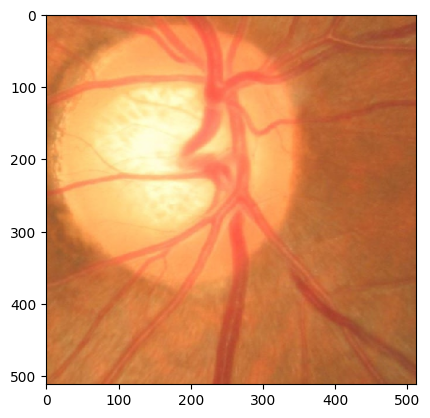

In [138]:
plt.imshow(image)

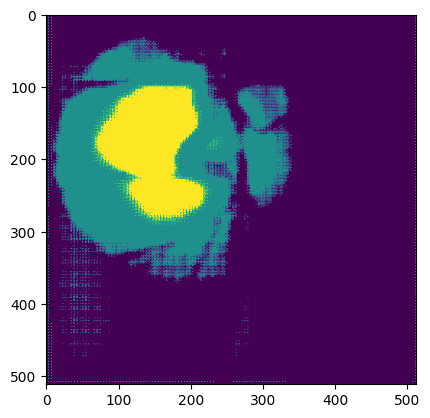

In [139]:
plt.imshow(predicted)

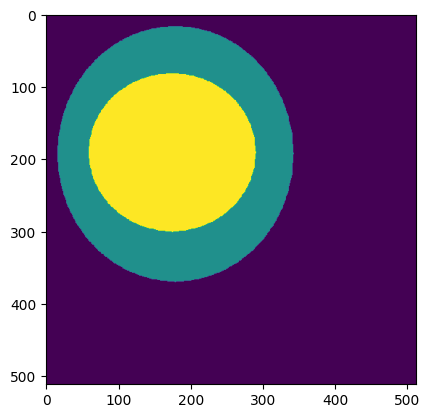

In [140]:
plt.imshow(ground_truth)

In [141]:
get_accuracy(predicted, ground_truth)

0.8312187194824219

In [142]:
get_IoU(predicted, ground_truth)

0.7212643678160919

In [143]:
dice_coefficient(predicted, ground_truth, "disk")

0.5948860049247742

In [144]:
TP_disk, TN_disk, FP_disk, FN_disk, comparison_disk = confusion_matrix(predicted, ground_truth, "disk")

(512, 512)


In [145]:
TP_cup, TN_cup, FP_cup, FN_cup, comparison_cup =confusion_matrix(predicted, ground_truth, "cup")

(512, 512)


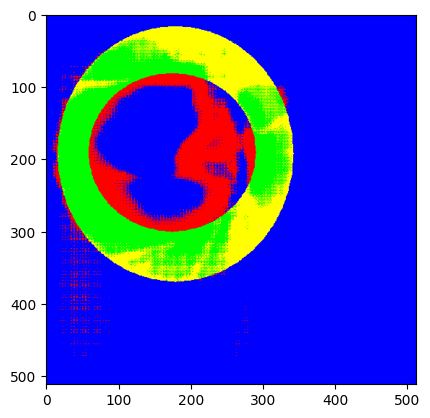

In [146]:
plt.imshow(comparison_disk)


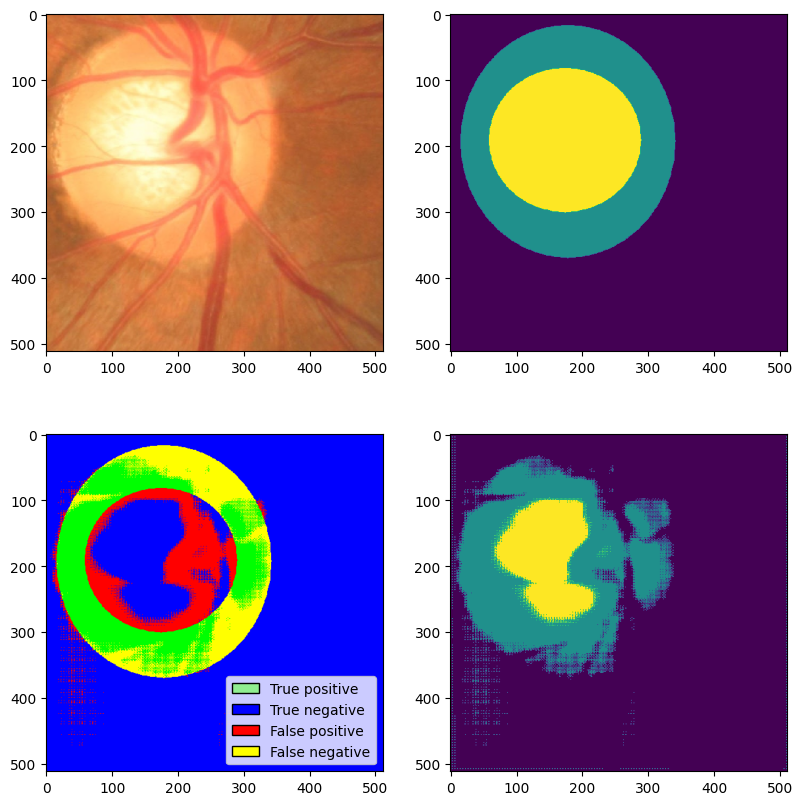

In [147]:
plt.figure(figsize=(20,20))
plt.subplot(2,4,1)  #2,4,1
plt.imshow(image)  
plt.subplot(1,4,2)   #
plt.imshow(predicted)
plt.subplot(2,4,2)   #2,4,2
plt.imshow(ground_truth)
plt.subplot(1,4,1)   #1,4,1
plt.imshow(comparison_disk)
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='True positive'),
    Patch(facecolor='blue', edgecolor='black', label='True negative'),
    Patch(facecolor='red', edgecolor='black', label='False positive'),
    Patch(facecolor='yellow', edgecolor='black', label='False negative'),
]
plt.legend(handles=legend_elements, loc='lower right')

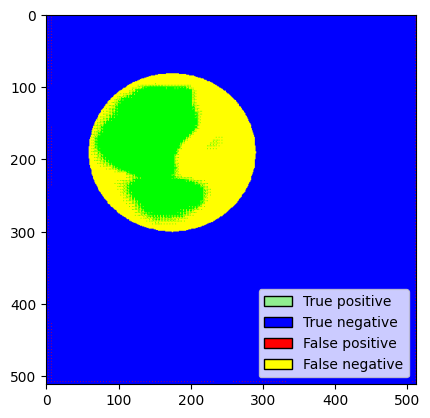

In [148]:
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='True positive'),
    Patch(facecolor='blue', edgecolor='black', label='True negative'),
    Patch(facecolor='red', edgecolor='black', label='False positive'),
    Patch(facecolor='yellow', edgecolor='black', label='False negative'),
]
plt.legend(handles=legend_elements, loc='lower right')
plt.imshow(comparison_cup)

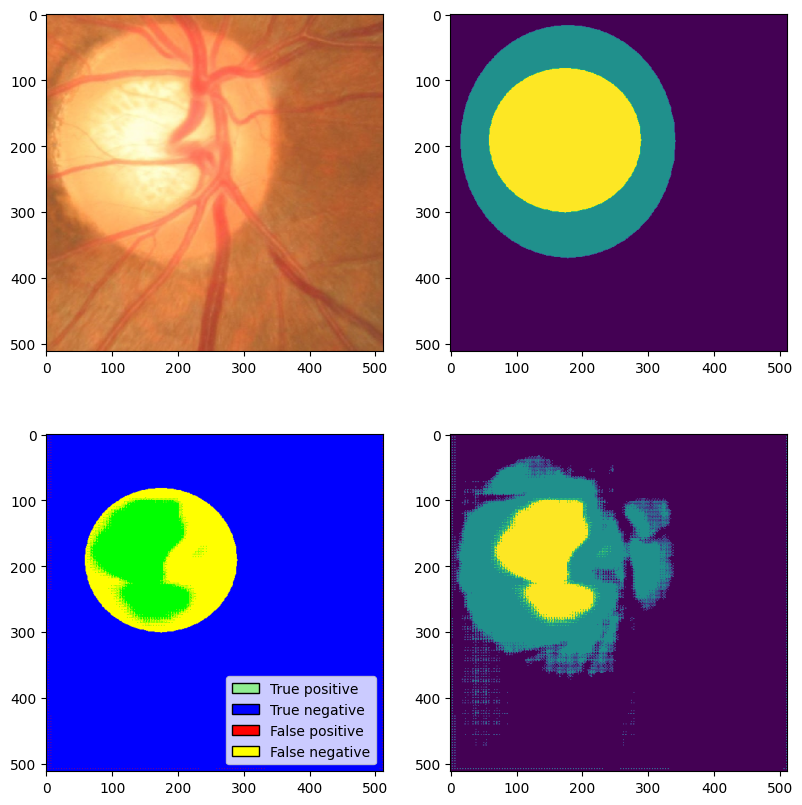

In [120]:
plt.figure(figsize=(20,20))
plt.subplot(2,4,1)  #2,4,1
plt.imshow(image)  
plt.subplot(1,4,2)   #
plt.imshow(predicted)
plt.subplot(2,4,2)   #2,4,2
plt.imshow(ground_truth)
plt.subplot(1,4,1)   #1,4,1
plt.imshow(comparison_cup)
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='True positive'),
    Patch(facecolor='blue', edgecolor='black', label='True negative'),
    Patch(facecolor='red', edgecolor='black', label='False positive'),
    Patch(facecolor='yellow', edgecolor='black', label='False negative'),
]
plt.legend(handles=legend_elements, loc='lower right')

In [168]:
unique_values, counts = np.unique(predicted, return_counts=True)
for value, count in zip(unique_values, counts):
    print(str(value) +":    "+str(count))

0:    246664
1:    15480


In [176]:
images_list = os.listdir(r''+folder+r'\LinkNetResults\Test_results_2\images')
predicted_list = os.listdir(r''+folder+r'\LinkNetResults\Test_results_2\results')
ground_truth_list = os.listdir(r''+folder+r'\LinkNetResults\Test_results_2\gt')

In [190]:
global_acc_test2 = 0
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results_2\results\/'+prediction).get('mask')
    ground_truth = loadmat(r''+folder+r'\LinkNetResults\Test_results_2\gt\/'+gt).get('mask')
    ground_truth[ground_truth == 2] =1
    predicted[predicted == 2] = 1
    
    ground_truth = Image.fromarray(ground_truth)
    ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    acc = get_accuracy(predicted, ground_truth)
    print(acc)
    global_acc_test2 += acc
global_acc_test2 = global_acc_test2/len(images_list)

0.9012031555175781
0.8625602722167969
0.9249382019042969
0.8928489685058594
0.9456787109375
0.7973213195800781
0.8451766967773438
0.7692146301269531


In [191]:
global_acc_test2

0.8673677444458008

In [192]:
global_iou_test2 = 0
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results_2\results\/'+prediction).get('mask')
    ground_truth = loadmat(r''+folder+r'\LinkNetResults\Test_results_2\gt\/'+gt).get('mask')
    ground_truth[ground_truth == 2] =1
    predicted[predicted == 2] = 1
    
    ground_truth = Image.fromarray(ground_truth)
    ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    iou = get_IoU(predicted, ground_truth)
    print(iou)
    global_iou_test2 += iou
global_iou_test2 = global_iou_test2/len(images_list)

0.7212643678160919
0.7497742836109066
0.7582470236998268
0.682067708745996
0.7598245909934221
0.11983765426985836
0.6041896254108193
0.6274944431103805


In [193]:
global_iou_test2

0.6278374622071627

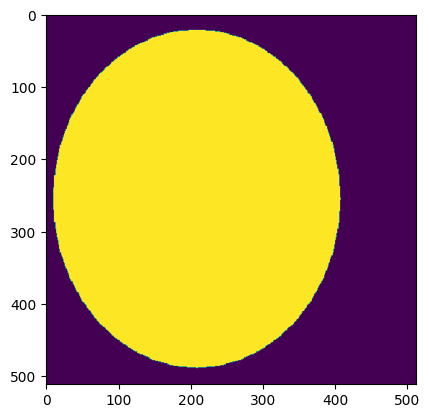

In [194]:
plt.imshow(ground_truth)

In [195]:
global_dice_test2 = 0
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results_2\results\/'+prediction).get('mask')
    ground_truth = loadmat(r''+folder+r'\LinkNetResults\Test_results_2\gt\/'+gt).get('mask')
    ground_truth[ground_truth == 2] =1
    predicted[predicted == 2] = 1
    
    ground_truth = Image.fromarray(ground_truth)
    ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    dice = dice_coefficient(predicted, ground_truth, 'disk')
    print(dice)
    global_dice_test2 += dice
global_dice_test2 = global_dice_test2/len(images_list)

0.8380634188652039
0.8569954037666321
0.8625034093856812
0.8109872341156006
0.8635231256484985
0.21402683854103088
0.7532646059989929
0.7711171507835388


In [196]:
global_dice_test2

0.7463101483881474

In [27]:
# global_TP_disk=0
# global_TN_disk=0
# global_FP_disk=0
# global_FN_disk = 0
# for prediction,gt in zip(predicted_list, ground_truth_list):
#     predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results_2\results\/'+prediction).get('mask')
#     ground_truth = loadmat(r''+folder+r'\LinkNetResults\Test_results_2\gt\/'+gt).get('mask')

#     ground_truth = Image.fromarray(ground_truth)
#     ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
#     ground_truth = np.array(ground_truth)
#     TP_disk, TN_disk, FP_disk, FN_disk, comparison_disk = confusion_matrix(predicted, ground_truth, "disk")
#     global_TP_disk += TP_disk
#     global_TN_disk +=  TN_disk
#     global_FP_disk += FP_disk
#     global_FN_disk += FN_disk
    
# global_TP_disk = global_TP_disk/len(images_list)
# global_TN_disk = global_TN_disk/len(images_list)
# global_FP_disk = global_FP_disk/len(images_list)
# global_FN_disk = global_FN_disk/len(images_list)

# Centered data

In [28]:
image = Image.open(r''+folder+r'\LinkNetResults\Test_results\images\615.jpg')
predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results\results\615.mat').get('mask')
predicted = np.squeeze(predicted, axis=-1)
ground_truth = Image.open(r''+folder+r'\LinkNetResults\Test_results\gt\615.png')
ground_truth = np.array(ground_truth)
ground_truth[ground_truth == 2] =1

In [29]:
get_accuracy(predicted, ground_truth)

0.9669532775878906

In [30]:
get_IoU(predicted, ground_truth)

0.8731606612102666

In [31]:
dice_coefficient(predicted, ground_truth, "disk")

0.9322859048843384

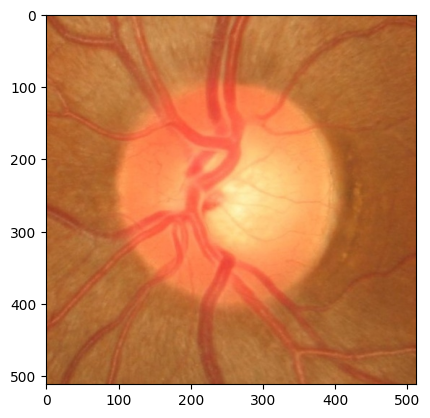

In [32]:
plt.imshow(image)

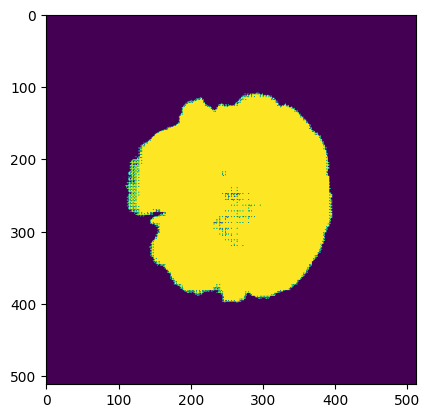

In [33]:
plt.imshow(predicted)

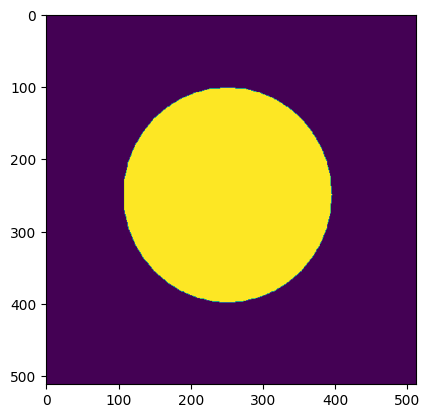

In [34]:
plt.imshow(ground_truth)

In [35]:
TP_disk, TN_disk, FP_disk, FN_disk, comparison_disk = confusion_matrix(predicted, ground_truth, "disk")

(512, 512)


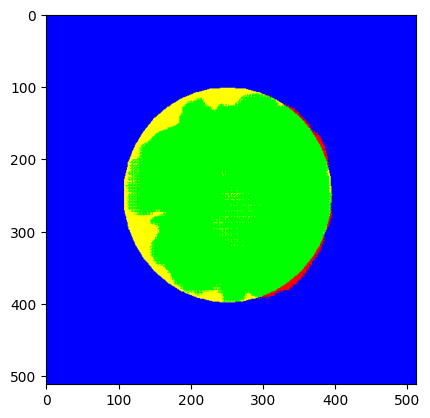

In [36]:
plt.imshow(comparison_disk)

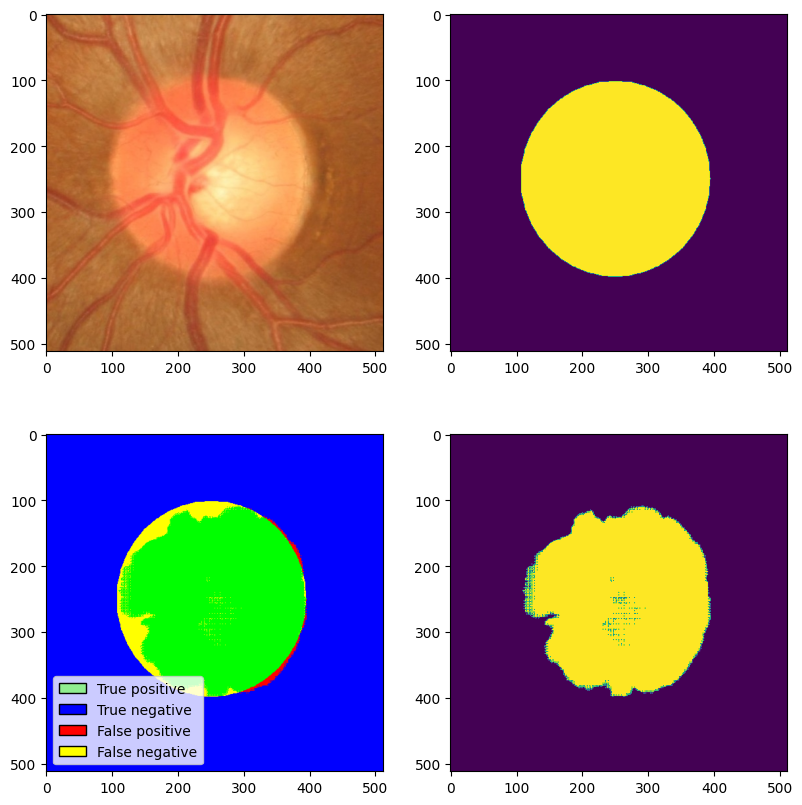

In [37]:
plt.figure(figsize=(20,20))
plt.subplot(2,4,1)  #2,4,1
plt.imshow(image)  
plt.subplot(1,4,2)   #
plt.imshow(predicted)
plt.subplot(2,4,2)   #2,4,2
plt.imshow(ground_truth)
plt.subplot(1,4,1)   #1,4,1
plt.imshow(comparison_disk)
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='True positive'),
    Patch(facecolor='blue', edgecolor='black', label='True negative'),
    Patch(facecolor='red', edgecolor='black', label='False positive'),
    Patch(facecolor='yellow', edgecolor='black', label='False negative'),
]
plt.legend(handles=legend_elements, loc='lower left')

In [38]:
images_list = os.listdir(r''+folder+r'\LinkNetResults\Test_results\images')
predicted_list = os.listdir(r''+folder+r'\LinkNetResults\Test_results\results')
ground_truth_list = os.listdir(r''+folder+r'\LinkNetResults\Test_results\gt')

In [39]:
global_acc_test = 0
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results\results\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(r''+folder+r'\LinkNetResults\Test_results\gt\/'+gt)

    ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 2] =1
    
    acc = get_accuracy(predicted, ground_truth)
    print(acc)
    global_acc_test += acc
global_acc_test = global_acc_test/len(images_list)

0.9494438171386719
0.9581871032714844
0.9454803466796875
0.9216651916503906
0.9521141052246094
0.9269981384277344
0.9411392211914062
0.9570083618164062
0.9392662048339844
0.9791221618652344
0.93548583984375
0.9643020629882812
0.9734115600585938
0.8657989501953125
0.9669532775878906
0.9677200317382812
0.8042373657226562
0.9634742736816406
0.9579277038574219
0.7478370666503906
0.8156280517578125
0.927398681640625
0.9237785339355469
0.9008598327636719
0.9688682556152344
0.96771240234375
0.9633026123046875
0.9663848876953125
0.9548912048339844
0.9623947143554688
0.9696159362792969
0.965362548828125
0.9386215209960938
0.9406890869140625
0.9304275512695312
0.8855628967285156
0.9293785095214844
0.9711074829101562
0.9388275146484375
0.9516067504882812
0.9194793701171875
0.8959846496582031
0.9381103515625
0.9354743957519531
0.9463043212890625
0.963134765625
0.915618896484375
0.974395751953125
0.9196662902832031
0.943756103515625


In [40]:
global_acc_test

0.9348383331298828

In [41]:
global_iou_test = 0
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results\results\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(r''+folder+r'\LinkNetResults\Test_results\gt\/'+gt)

    ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 2] =1
    
    iou = get_IoU(predicted, ground_truth)
    #print(iou)
    global_iou_test += iou
global_iou_test = global_iou_test/len(images_list)

In [42]:
global_iou_test

0.8244864044001186

In [43]:
global_dice_test = 0
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results\results\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(r''+folder+r'\LinkNetResults\Test_results\gt\/'+gt)

    ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 2] =1
    dice = dice_coefficient(torch.from_numpy(predicted), torch.from_numpy(ground_truth), 'disk')
    print(dice)
    global_dice_test += dice
global_dice_test = global_dice_test/len(images_list)

0.925895094871521
0.9371159672737122
0.9068487882614136
0.8945349454879761
0.9220606088638306
0.8754369020462036
0.9042720794677734
0.9293266534805298
0.9293464422225952
0.9722302556037903
0.8736004829406738
0.9243088364601135
0.9532678723335266
0.7757464647293091
0.9322859048843384
0.9469174146652222
0.7331523895263672
0.9295152425765991
0.9275270700454712
0.639614462852478
0.7538151144981384
0.9041778445243835
0.8849093914031982
0.901167094707489
0.959381639957428
0.9573025703430176
0.93747478723526
0.9461323022842407
0.9275078177452087
0.9462416172027588
0.9569647908210754
0.9526826739311218
0.8819879293441772
0.9049668312072754
0.8794803619384766
0.8222312927246094
0.8879975080490112
0.9549782872200012
0.8988634943962097
0.9217657446861267
0.8736532330513
0.8415639400482178
0.9136911034584045
0.9195477962493896
0.8999488353729248
0.9433030486106873
0.8684757947921753
0.9595096707344055
0.8787643313407898
0.9206783175468445


In [44]:
global_dice_test

0.9006433808803558

# Vessels

In [84]:
image = Image.open(r''+folder+r'\LinkNetResults\Test_results_4\images\1_A.png')
predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results_4\results\1_A.mat').get('mask')
predicted = np.squeeze(predicted, axis=-1)
ground_truth = Image.open(r''+folder+r'\LinkNetResults\Test_results_4\gt\1_A.png')
ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
ground_truth = np.array(ground_truth)
ground_truth[ground_truth == 255] =1
ground_truth = ground_truth[:,:,0]

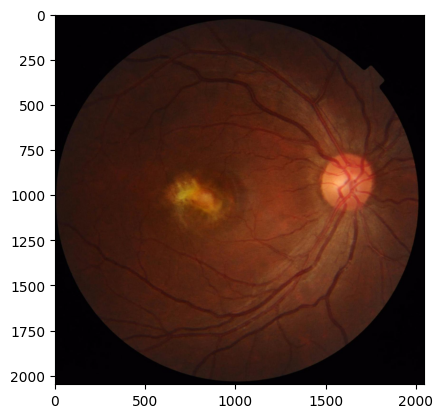

In [85]:
plt.imshow(image)

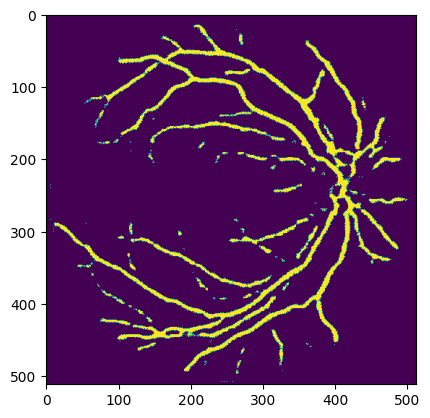

In [88]:
plt.imshow(predicted)

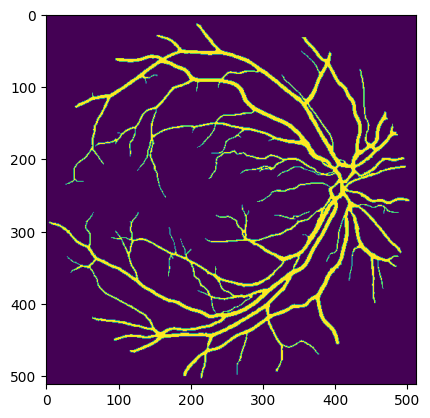

In [89]:
plt.imshow(ground_truth)

In [90]:
unique_values, counts = np.unique(ground_truth, return_counts=True)
for value, count in zip(unique_values, counts):
    print(str(value) +":    "+str(count))

0:    236359
1:    25785


In [92]:
get_accuracy(predicted, ground_truth)

0.9491157531738281

In [93]:
get_IoU(predicted, ground_truth)

0.5646966680808014

In [94]:
dice_coefficient(predicted, ground_truth, "disk")

0.721796989440918

In [95]:
TP_disk, TN_disk, FP_disk, FN_disk, comparison_disk = confusion_matrix(predicted, ground_truth, "disk")

(512, 512)


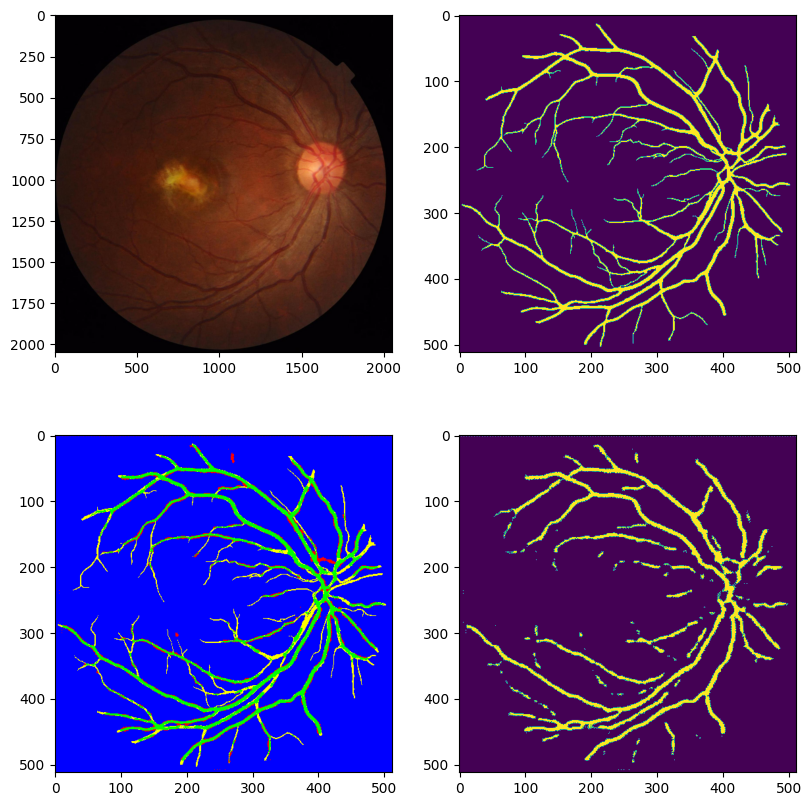

In [107]:
plt.figure(figsize=(20,20))
# legend_elements = [
#     Patch(facecolor='lightgreen', edgecolor='black', label='True positive'),
#     Patch(facecolor='blue', edgecolor='black', label='True negative'),
#     Patch(facecolor='red', edgecolor='black', label='False positive'),
#     Patch(facecolor='yellow', edgecolor='black', label='False negative'),
# ]
# plt.legend(handles=legend_elements, loc='upper left')
plt.subplot(2,4,1)  #2,4,1
plt.imshow(image)  
plt.subplot(1,4,2)   #
plt.imshow(predicted)
plt.subplot(2,4,2)   #2,4,2
plt.imshow(ground_truth)
plt.subplot(1,4,1)   #1,4,1
plt.imshow(comparison_disk)



In [55]:
images_list = os.listdir(r''+folder+r'\LinkNetResults\Test_results_4\images')
predicted_list = os.listdir(r''+folder+r'\LinkNetResults\Test_results_4\results')
ground_truth_list = os.listdir(r''+folder+r'\LinkNetResults\Test_results_4\gt')

In [56]:
global_acc_test4 = 0
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results_4\results\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(r''+folder+r'\LinkNetResults\Test_results_4\gt\/'+gt)

    ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 255] =1
    ground_truth = ground_truth[:,:,0]
    
    acc = get_accuracy(predicted, ground_truth)
    print(acc)
    global_acc_test4 += acc
global_acc_test4 = global_acc_test4/len(images_list)

0.9594573974609375
0.9691886901855469
0.9605484008789062
0.944549560546875
0.9541854858398438
0.9571800231933594
0.9611663818359375
0.946746826171875
0.9799118041992188
0.9552001953125
0.9599266052246094
0.9549560546875
0.9545822143554688
0.9618186950683594
0.98211669921875
0.9824676513671875
0.95404052734375
0.9639892578125
0.9568252563476562
0.9504966735839844
0.9803695678710938
0.9492378234863281
0.957427978515625
0.9792098999023438
0.9907341003417969
0.9814834594726562
0.9712905883789062
0.9618110656738281
0.9561500549316406
0.9616470336914062
0.9578781127929688
0.956329345703125
0.9521560668945312
0.9550514221191406
0.9543609619140625
0.9620361328125
0.9816703796386719
0.9571456909179688
0.9691810607910156
0.9800376892089844
0.9807395935058594
0.984649658203125
0.9511489868164062
0.9443702697753906
0.9599723815917969
0.9542732238769531
0.9497146606445312
0.9460601806640625
0.9688644409179688
0.975311279296875
0.9464530944824219
0.9567413330078125
0.9746208190917969
0.9805564880371

In [57]:
global_acc_test4

0.9553365707397461

In [58]:
global_iou_test4 = 0
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results_4\results\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(r''+folder+r'\LinkNetResults\Test_results_4\gt\/'+gt)

    ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 255] =1
    ground_truth = ground_truth[:,:,0]
    
    iou = get_IoU(predicted, ground_truth)
    print(iou)
    
    global_iou_test4 += iou
global_iou_test4 = global_iou_test4/len(images_list)

0.5107039270751808
0.3252861080945619
0.37616117746410904
0.3453726638144562
0.42839465042120795
0.5569195547485593
0.6219127205199628
0.5277561652176854
0.36850941359875283
0.5773715272779617
0.5105302394930575
0.5355752212389381
0.39152654980324014
0.5769474618538399
0.2816426601287159
0.35539971949509114
0.5048088779284834
0.4903633320736382
0.4864092208558334
0.5662912335817654
0.18421052631578946
0.44880291607986084
0.553974661284521
0.46531933679976456
0.051542366263178443
0.03804994054696789
0.6074278858692818
0.6123223482941563
0.3801563763817741
0.3685466649918352
0.477598523915409
0.3085703931871716
0.5195188292533425
0.533254109724698
0.5587844814869449
0.4959481361426256
0.4237227152794435
0.5533023181836256
0.4074372891301159
0.2367269544924154
0.3920529801324503
0.35305466237942124
0.5684437554761744
0.4333177896945675
0.3535608674223756
0.5042597187758479
0.5544062468309502
0.533148441627047
0.24926416482707872
0.38490781220300324
0.5159822075100858
0.4772266273280472
0.

In [59]:
global_iou_test4

0.4586152045174136

In [60]:
global_dice_test4 = 0
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results_4\results\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(r''+folder+r'\LinkNetResults\Test_results_4\gt\/'+gt)

    ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 255] =1
    ground_truth = ground_truth[:,:,0]
    
    dice = dice_coefficient(predicted, ground_truth, 'disk')
    print(dice)

    global_dice_test4 += dice
global_dice_test4 = global_dice_test4/len(images_list)

0.6761138439178467
0.4908919036388397
0.5466818809509277
0.5134230256080627
0.5998267531394958
0.7154121398925781
0.7668880224227905
0.6908905506134033
0.538555920124054
0.732067883014679
0.6759616136550903
0.6975564956665039
0.56272953748703
0.7317269444465637
0.43950262665748596
0.5244205594062805
0.6709275841712952
0.6580453515052795
0.6544755101203918
0.7230982780456543
0.31111112236976624
0.6195499897003174
0.7129777073860168
0.6351097822189331
0.09803193807601929
0.07331042736768723
0.7557762265205383
0.7595532536506653
0.5508888363838196
0.5385956764221191
0.6464523673057556
0.4716145098209381
0.683793842792511
0.695584774017334
0.7169489860534668
0.6630552411079407
0.5952320694923401
0.712420642375946
0.5789775252342224
0.3828281760215759
0.5632730722427368
0.5218631029129028
0.7248506546020508
0.604636013507843
0.5224159359931946
0.6704423427581787
0.7133350968360901
0.6954948902130127
0.3990575671195984
0.5558605790138245
0.6807233095169067
0.6461116075515747
0.54415893554687

In [61]:
global_dice_test4

0.6221205722913146

# Centered data tuned

In [62]:
image = Image.open(r''+folder+r'\LinkNetResults\Test_results_3\images\615.jpg')
predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results_3\results\615.mat').get('mask')
predicted = np.squeeze(predicted, axis=-1)
ground_truth = Image.open(r''+folder+r'\LinkNetResults\Test_results_3\gt\615.png')
ground_truth = np.array(ground_truth)
ground_truth[ground_truth == 2] =1

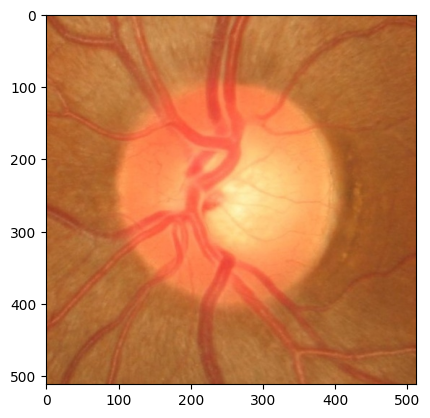

In [63]:
plt.imshow(image)

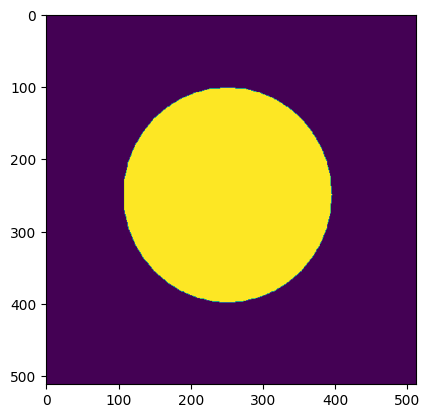

In [64]:
plt.imshow(ground_truth)

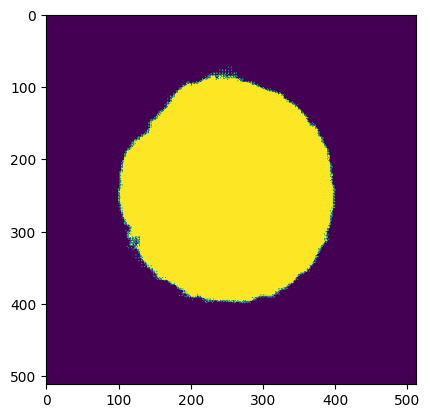

In [65]:
plt.imshow(predicted)

In [66]:
get_accuracy(predicted, ground_truth)

0.9810333251953125

In [67]:
get_IoU(predicted, ground_truth)

0.9307858286350664

In [68]:
dice_coefficient(predicted, ground_truth, "disk")

0.9641523361206055

In [69]:
TP_disk, TN_disk, FP_disk, FN_disk, comparison_disk = confusion_matrix(predicted, ground_truth, "disk")

(512, 512)


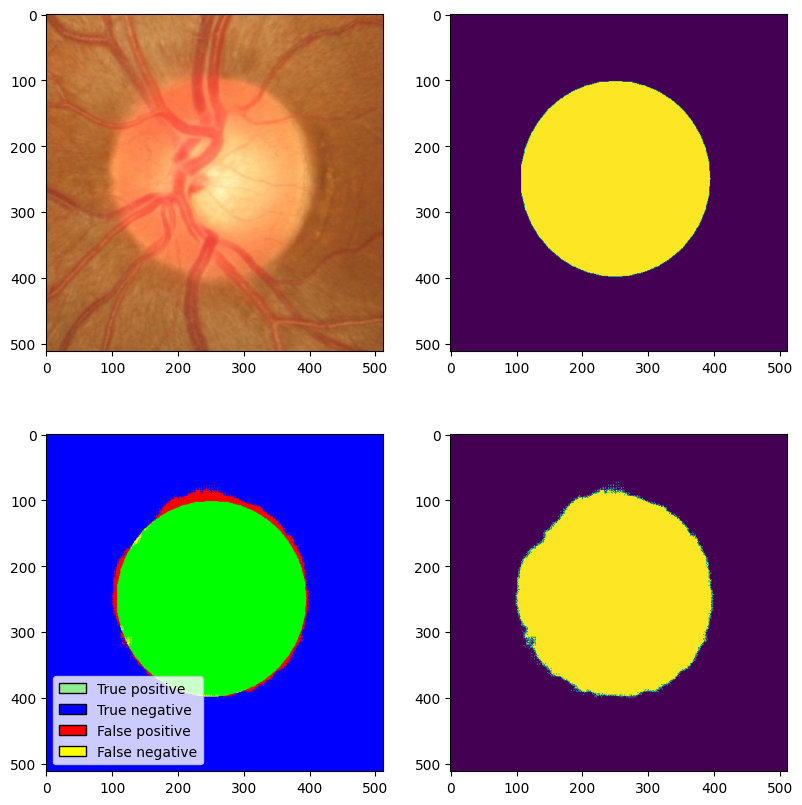

In [70]:
plt.figure(figsize=(20,20))
plt.subplot(2,4,1)  #2,4,1
plt.imshow(image)  
plt.subplot(1,4,2)   #
plt.imshow(predicted)
plt.subplot(2,4,2)   #2,4,2
plt.imshow(ground_truth)
plt.subplot(1,4,1)   #1,4,1
plt.imshow(comparison_disk)
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='True positive'),
    Patch(facecolor='blue', edgecolor='black', label='True negative'),
    Patch(facecolor='red', edgecolor='black', label='False positive'),
    Patch(facecolor='yellow', edgecolor='black', label='False negative'),
]
plt.legend(handles=legend_elements, loc='lower left')

In [71]:
images_list = os.listdir(r''+folder+r'\LinkNetResults\Test_results_3\images')
predicted_list = os.listdir(r''+folder+r'\LinkNetResults\Test_results_3\results')
ground_truth_list = os.listdir(r''+folder+r'\LinkNetResults\Test_results_3\gt')

In [72]:
global_acc_test3 = 0
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results_3\results\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(r''+folder+r'\LinkNetResults\Test_results_3\gt\/'+gt)

    ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 2] =1
    
    acc = get_accuracy(predicted, ground_truth)
    #print(acc)
    global_acc_test3 += acc
global_acc_test3 = global_acc_test3/len(images_list)

In [73]:
global_acc_test3

0.9545267486572265

In [74]:
global_iou_test3 = 0
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results_3\results\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(r''+folder+r'\LinkNetResults\Test_results_3\gt\/'+gt)

    ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 2] =1
    
    iou = get_IoU(predicted, ground_truth)
    #print(iou)
    global_iou_test3 += iou
global_iou_test3 = global_iou_test3/len(images_list)

In [75]:
global_iou_test3

0.8823324064691462

In [76]:
global_dice_test3 = 0
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(r''+folder+r'\LinkNetResults\Test_results_3\results\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(r''+folder+r'\LinkNetResults\Test_results_3\gt\/'+gt)

    ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 2] =1
    dice = dice_coefficient(torch.from_numpy(predicted), torch.from_numpy(ground_truth), 'disk')
    #print(dice)
    global_dice_test3 += dice
global_dice_test3 = global_dice_test3/len(images_list)

In [77]:
global_dice_test3

0.9351727533340454

# Graphs

In [78]:
print(global_acc_test)
print(global_acc_test2)
print(global_acc_test3)
print(global_acc_test4)

0.9348383331298828
0.7812347412109375
0.9545267486572265
0.9553365707397461


In [79]:
print(global_iou_test)
print(global_iou_test2)
print(global_iou_test3)
print(global_iou_test4)

0.8244864044001186
0.6278374622071627
0.8823324064691462
0.4586152045174136


In [80]:
print(global_dice_test)
print(global_dice_test2)
print(global_dice_test3)
print(global_dice_test4)

0.9006433808803558
0.39591985202753127
0.9351727533340454
0.6221205722913146


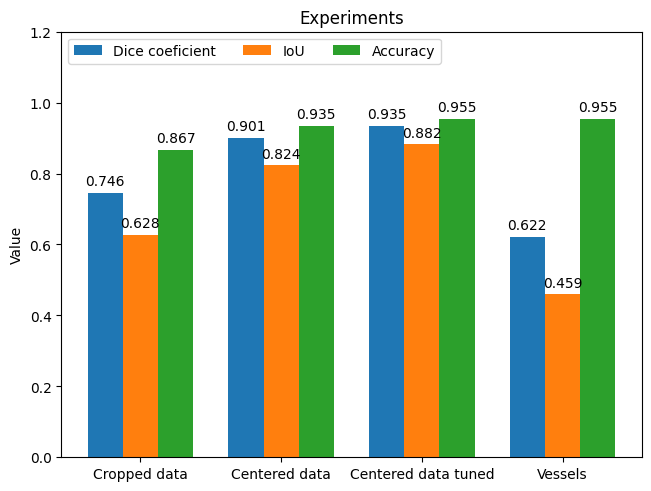

In [136]:

import matplotlib.pyplot as plt
import numpy as np

species = ("Cropped data", "Centered data", "Centered data tuned", "Vessels")
measurements_values = {
    'Dice coeficient': (round(global_dice_test2,3), round(global_dice_test,3), round(global_dice_test3,3), round(global_dice_test4,3)),
    'IoU': (round(global_iou_test2,3) ,round(global_iou_test,3), round(global_iou_test3,3), round(global_iou_test4,3)),
    'Accuracy': (round(global_acc_test2,3), round(global_acc_test,3), round(global_acc_test3,3), round(global_acc_test4,3)),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in measurements_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('Experiments')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.2)

plt.show()